In [129]:
# pip install if needed
!pip install transformers google-api-python-client openai -q

import json
import requests
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, T5ForConditionalGeneration, T5Tokenizer
from googleapiclient.discovery import build


In [130]:
!pip install gdown

import gdown
import os

# Скачиваем архивы моделей
t5_file_id = "1PjlnG723Ug53RmWocgUOzqnIk1mPjqVB"  # T5 модель
roberta_file_id = "1PSEUte091ouNFaxuIuLYqaAnIaAAOCBi"  # RoBERTa модель

# Выходные пути
t5_output = "t5_model.zip"
roberta_output = "roberta_model.zip"

# Скачивание
gdown.download(f"https://drive.google.com/uc?id={t5_file_id}", t5_output, quiet=False)
gdown.download(f"https://drive.google.com/uc?id={roberta_file_id}", roberta_output, quiet=False)

# Распаковка архивов
!unzip -o t5_model.zip -d ./t5_model
!unzip -o roberta_model.zip -d ./roberta_model

Downloading...
From (original): https://drive.google.com/uc?id=1PjlnG723Ug53RmWocgUOzqnIk1mPjqVB
From (redirected): https://drive.google.com/uc?id=1PjlnG723Ug53RmWocgUOzqnIk1mPjqVB&confirm=t&uuid=76112254-81e3-4997-9989-04dc7c3a4f68
To: /content/t5_model.zip
100%|██████████| 919M/919M [00:20<00:00, 44.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1PSEUte091ouNFaxuIuLYqaAnIaAAOCBi
From (redirected): https://drive.google.com/uc?id=1PSEUte091ouNFaxuIuLYqaAnIaAAOCBi&confirm=t&uuid=7d55d229-7f88-422b-85ed-398210d37448
To: /content/roberta_model.zip
100%|██████████| 1.30G/1.30G [00:19<00:00, 65.8MB/s]


Archive:  t5_model.zip
  inflating: ./t5_model/config.json  
  inflating: ./t5_model/tokenizer_config.json  
  inflating: ./t5_model/model.safetensors  
  inflating: ./t5_model/added_tokens.json  
  inflating: ./t5_model/generation_config.json  
  inflating: ./t5_model/special_tokens_map.json  
  inflating: ./t5_model/spiece.model  
Archive:  roberta_model.zip
  inflating: ./roberta_model/vocab.json  
  inflating: ./roberta_model/model.safetensors  
  inflating: ./roberta_model/tokenizer_config.json  
  inflating: ./roberta_model/merges.txt  
  inflating: ./roberta_model/special_tokens_map.json  
  inflating: ./roberta_model/tokenizer.json  
  inflating: ./roberta_model/config.json  


In [131]:
# API-ключи и настройки
GOOGLE_API_KEY = ""
GOOGLE_CSE_ID = ""

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Загрузка моделей
# Путь к T5
t5_path = "./t5_model"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_path)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_path).to(DEVICE)

# Путь к RoBERTa
roberta_path = "./roberta_model"
roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_path).to(DEVICE)





Using device: cpu


In [132]:
roberta_model.config.id2label

{0: 'CONTRADICTION', 1: 'NEUTRAL', 2: 'ENTAILMENT'}

In [133]:
def google_search(query, api_key, cse_id, num_results=5):
    service = build("customsearch", "v1", developerKey=api_key)
    res = service.cse().list(q=query, cx=cse_id, num=num_results).execute()
    results = []
    for item in res.get("items", []):
        results.append({
            "snippet": item.get("snippet", ""),
            "link": item.get("link", ""),
            "title": item.get("title", ""),
            "source": item.get("displayLink", "")
        })
    return results


In [134]:
from urllib.parse import urlparse

def get_domain(url):
    try:
        return urlparse(url).netloc.replace("www.", "")
    except:
        return "unknown"


In [135]:
from collections import defaultdict

# Байесовская модель доверия (alpha=1, beta=1 — априорное предположение)
bayesian_trust = defaultdict(lambda: {"alpha": 1, "beta": 1})

def update_bayesian_trust(domain, is_correct):
    if is_correct:
        bayesian_trust[domain]["alpha"] += 1
    else:
        bayesian_trust[domain]["beta"] += 1

def get_bayesian_score(domain):
    stats = bayesian_trust[domain]
    return stats["alpha"] / (stats["alpha"] + stats["beta"])


In [136]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import numpy as np
import re
import datetime

# Загружаем заранее
model = SentenceTransformer("all-MiniLM-L6-v2")

# Первоначальное доверие к доменам 
SOURCE_TRUST = {
    "bbc.com": 0.9,
    "wikipedia.org": 0.85,
    "sciencefocus.com": 0.8,
    "nytimes.com": 0.8,
    "reddit.com": 0.3,
    "quora.com": 0.4,
}

def extract_year(text):
    """Пытаемся извлечь год из текста"""
    match = re.search(r"\b(19|20)\d{2}\b", text)
    if match:
        try:
            year = int(match.group(0))
            current_year = datetime.datetime.now().year
            return max(0, 1 - (current_year - year) / 10)  # нормируем от 1 до 0
        except:
            return 0.5
    return 0.5  # нейтральная актуальность

def get_trust(source_url):
    for domain, trust in SOURCE_TRUST.items():
        if domain in source_url:
            return trust
    return 0.5  # по умолчанию

def rank_snippets_by_context(question, retrieved_snippets):
    question_embedding = model.encode([question])[0]

    ranked = []
    for snippet in retrieved_snippets:
        text = snippet["snippet"]
        source = snippet["link"]
        snippet_embedding = model.encode([text])[0]
        similarity = cosine_similarity([question_embedding], [snippet_embedding])[0][0]

        trust = get_trust(source)
        recency = extract_year(text)

        # Весовая формула: 60% семантика, 25% доверие, 15% актуальность
        total_score = 0.6 * similarity + 0.25 * trust + 0.15 * recency

        ranked.append({
            **snippet,
            "similarity": similarity,
            "trust": trust,
            "recency": recency,
            "score": total_score
        })

    # Сортируем по total_score убыванию
    return sorted(ranked, key=lambda x: x["score"], reverse=True)


In [137]:
def generate_answer(question, context, max_length=128):
    input_text = f"question: {question} context: {context}"
    inputs = t5_tokenizer(input_text, return_tensors="pt").to(DEVICE)
    output = t5_model.generate(**inputs, max_length=max_length)
    return t5_tokenizer.decode(output[0], skip_special_tokens=True)


In [138]:
def verify_claim_roberta(claim, context):
    pair = roberta_tokenizer(claim, context, return_tensors="pt", truncation=True).to(DEVICE)
    logits = roberta_model(**pair).logits
    pred = torch.argmax(logits, dim=1).item()
    label_map = {2: "SUPPORTS", 0: "REFUTES", 1: "NOT ENOUGH INFO"}
    return label_map[pred], torch.softmax(logits, dim=1)[0].tolist()


In [139]:
source_trust = {}

def update_trust(source, verified):
    if source not in source_trust:
        source_trust[source] = [0, 0]  # [success, total]
    source_trust[source][1] += 1
    if verified:
        source_trust[source][0] += 1

def get_trust_score(source):
    success, total = source_trust.get(source, (0, 1))
    return success / total


In [172]:
import pandas as pd

def sources_contradict(votes):
    """Определяет, есть ли противоречие между источниками."""
    non_zero = [label for label, count in votes.items() if count > 0]
    return len(non_zero) > 1

# Пример для одного вопроса — проверить голосование источников
def evaluate_sources_individually(claim, snippets, verify_func):
    """
    Оценивает каждый сниппет по утверждению с помощью функции верификации.
    Возвращает:
        - голоса по каждому классу
        - список с метками и текстами
    """
    votes = {"SUPPORTS": 2, "REFUTES": 0, "NOT ENOUGH INFO": 1}
    all_scores = []

    for snippet in snippets:
        label, scores = verify_func(claim, snippet)
        votes[label] += 1
        all_scores.append({
            "snippet": snippet,
            "label": label,
            "scores": scores
        })

    return votes, all_scores


In [179]:
def evaluate_pipeline(question):
    print("🔎 Вопрос:", question)

    # Шаг 1: Получение и ранжирование источников
    retrieved = google_search(question, GOOGLE_API_KEY, GOOGLE_CSE_ID, num_results=7)
    ranked = rank_snippets_by_context(question, retrieved)
    snippets = [r["snippet"] for r in ranked]
    context = " ".join(snippets)

    print(context)

    # Шаг 2: Генерация ответа
    answer = generate_answer(question, context)

    # Шаг 3: Формирование утверждения
    claim = f"The answer to the question '{question}' is {answer}."

    # Шаг 4: Верификация утверждения на уровне всего контекста
    label, scores = verify_claim_roberta(claim, context)

    # Шаг 5: Верификация по отдельным источникам
    source_votes, source_eval = evaluate_sources_individually(claim, snippets, verify_claim_roberta)
    contradiction_flag = sources_contradict(source_votes)

    # Шаг 6: Вывод информации
    print("\n📚 Использованные источники:")
    for i, r in enumerate(ranked, 1):
        print(f"{i}) {r['title']} — {r['link']}")

    print("\n🤖 Ответ модели:", answer)
    print("🧾 Утверждение:", claim)
    print(f"✅ Верификация: {label}, вероятности: {np.round(scores, 3).tolist()}")

    print("\n🔍 Оценки отдельных источников:")
    for i, (vote, r) in enumerate(zip(source_votes, ranked), 1):
        print(f"{i}) [{vote}] {r['title']} — {r['link']}")

    print(f"\n⚠️ Противоречие между источниками: {'Да' if contradiction_flag else 'Нет'}")


In [208]:
question = "What is the most difficult programming language?"

evaluate_pipeline(question)


🔎 Вопрос: What is the most difficult programming language?
Jan 18, 2024 ... In this blog, we will delve into the top 7 hardest programming languages, exploring the challenges they present to developers and the unique features that make ... Jun 18, 2023 ... What are the most difficult and easiest programming languages to learn for you? Based on my experience, I find JavaScript, Java, and C++ the ... Jan 31, 2025 ... What Are The Hardest Coding Languages? · C++ · Malbolge · Haskell · INTERCAL · BrainF**k · COW · Whitespace. Chris Morris and Edwin Brady ... Sep 5, 2023 ... Some commonly mentioned challenging languages include C++, Haskell, and Assembly. It is important for programmers to choose a language that aligns with their ... Jul 6, 2022 ... I'd say that the hardest language that's actually useful is C++ Template Metaprogramming. It's gotten a lot better over the last decade or so, but still rather ... Mar 25, 2023 ... HTML is one of the easiest programming languages. Its simple and

In [143]:
import random

questions = [
    # SUPPORTS
    {"question": "What is the capital of France?", "type": "fact", "statement": "The capital of France is Paris.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who painted the Mona Lisa?", "type": "fact", "statement": "The Mona Lisa was painted by Leonardo da Vinci.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the chemical formula for water?", "type": "fact", "statement": "The chemical formula for water is H2O.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the smallest planet in our solar system?", "type": "fact", "statement": "The smallest planet in our solar system is Mercury.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who wrote '1984'?", "type": "fact", "statement": "The book '1984' was written by George Orwell.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the tallest mountain in the world?", "type": "fact", "statement": "The tallest mountain in the world is Mount Everest.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who was the first man on the moon?", "type": "fact", "statement": "The first man on the moon was Neil Armstrong.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the capital of Japan?", "type": "fact", "statement": "The capital of Japan is Tokyo.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the primary gas in Earth's atmosphere?", "type": "fact", "statement": "The primary gas in Earth's atmosphere is nitrogen.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who discovered penicillin?", "type": "fact", "statement": "Penicillin was discovered by Alexander Fleming.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the most abundant element in the universe?", "type": "fact", "statement": "The most abundant element in the universe is hydrogen.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the capital of Russia?", "type": "fact", "statement": "The capital of Russia is Moscow.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who wrote 'The Great Gatsby'?", "type": "fact", "statement": "The book 'The Great Gatsby' was written by F. Scott Fitzgerald.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the smallest bone in the human body?", "type": "fact", "statement": "The smallest bone in the human body is the stapes.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the capital of Spain?", "type": "fact", "statement": "The capital of Spain is Madrid.", "label": "SUPPORTS", "category": "general"},
    {"question": "Who is known as the father of modern physics?", "type": "fact", "statement": "The father of modern physics is Albert Einstein.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the deepest ocean trench in the world?", "type": "fact", "statement": "The deepest ocean trench in the world is the Mariana Trench.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the largest continent on Earth?", "type": "fact", "statement": "The largest continent on Earth is Asia.", "label": "SUPPORTS", "category": "general"},
    {"question": "What is the hottest planet in our solar system?", "type": "fact", "statement": "The hottest planet in our solar system is Venus.", "label": "SUPPORTS", "category": "general"},

    # REFUTES
    {"question": "What is the capital of Italy?", "type": "fact", "statement": "The capital of Italy is Venice.", "label": "REFUTES", "category": "general"},
    {"question": "Who discovered electricity?", "type": "fact", "statement": "Electricity was discovered by Nikola Tesla.", "label": "REFUTES", "category": "general"},
    {"question": "What is the boiling point of water?", "type": "fact", "statement": "The boiling point of water is 150 degrees Celsius.", "label": "REFUTES", "category": "general"},
    {"question": "What is the atomic number of hydrogen?", "type": "fact", "statement": "The atomic number of hydrogen is 10.", "label": "REFUTES", "category": "general"},
    {"question": "What is the largest desert in the world?", "type": "fact", "statement": "The largest desert in the world is the Amazon Rainforest.", "label": "REFUTES", "category": "general"},
    {"question": "What is the capital of Canada?", "type": "fact", "statement": "The capital of Canada is Toronto.", "label": "REFUTES", "category": "general"},
    {"question": "Who was the first president of the United States?", "type": "fact", "statement": "The first president of the United States was Abraham Lincoln.", "label": "REFUTES", "category": "general"},
    {"question": "What is the speed of light?", "type": "fact", "statement": "The speed of light is 400,000 kilometers per second.", "label": "REFUTES", "category": "general"},
    {"question": "What is the largest ocean on Earth?", "type": "fact", "statement": "The largest ocean on Earth is the Atlantic.", "label": "REFUTES", "category": "general"},
    {"question": "What is the primary language spoken in Brazil?", "type": "fact", "statement": "The primary language spoken in Brazil is Spanish.", "label": "REFUTES", "category": "general"},
    {"question": "What is the capital of Germany?", "type": "fact", "statement": "The capital of Germany is Munich.", "label": "REFUTES", "category": "general"},
    {"question": "Who invented the airplane?", "type": "fact", "statement": "The airplane was invented by Nikola Tesla.", "label": "REFUTES", "category": "general"},
    {"question": "What is the currency of Japan?", "type": "fact", "statement": "The currency of Japan is the US Dollar.", "label": "REFUTES", "category": "general"},
    {"question": "What is the freezing point of water?", "type": "fact", "statement": "The freezing point of water is -50 degrees Celsius.", "label": "REFUTES", "category": "general"},
    {"question": "What is the largest city in Australia?", "type": "fact", "statement": "The largest city in Australia is Canberra.", "label": "REFUTES", "category": "general"},
    {"question": "What is the smallest country in the world?", "type": "fact", "statement": "The smallest country in the world is Monaco.", "label": "REFUTES", "category": "general"},
    {"question": "Who painted 'Starry Night'?", "type": "fact", "statement": "'Starry Night' was painted by Pablo Picasso.", "label": "REFUTES", "category": "general"},
    {"question": "What is the square root of 64?", "type": "fact", "statement": "The square root of 64 is 10.", "label": "REFUTES", "category": "general"},
    {"question": "Who discovered gravity?", "type": "fact", "statement": "Gravity was discovered by Galileo Galilei.", "label": "REFUTES", "category": "general"},

    # NOT ENOUGH INFO
    {"question": "What is the longest river in the world?", "type": "fact", "statement": "The longest river in the world is the Nile.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the population of Antarctica?", "type": "fact", "statement": "The population of Antarctica is 10,000.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the tallest tree species in the world?", "type": "fact", "statement": "The tallest tree species in the world is the Baobab.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the temperature on Venus?", "type": "fact", "statement": "The temperature on Venus is 500 degrees Celsius.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the national animal of Canada?", "type": "fact", "statement": "The national animal of Canada is the moose.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "Who was the first human in space?", "type": "fact", "statement": "The first human in space was Alan Shepard.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the chemical symbol for gold?", "type": "fact", "statement": "The chemical symbol for gold is Au.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the capital of South Africa?", "type": "fact", "statement": "The capital of South Africa is Johannesburg.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the largest animal ever recorded?", "type": "fact", "statement": "The largest animal ever recorded is the Megalodon.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the circumference of the Earth?", "type": "fact", "statement": "The circumference of the Earth is 40,000 miles.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the most common element in the universe?", "type": "fact", "statement": "The most common element in the universe is helium.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the distance between the Earth and the Moon?", "type": "fact", "statement": "The distance between the Earth and the Moon is 384,000 kilometers.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the highest recorded temperature on Earth?", "type": "fact", "statement": "The highest recorded temperature on Earth is 58 degrees Celsius.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the oldest book ever written?", "type": "fact", "statement": "The oldest book ever written is 'The Epic of Gilgamesh'.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the origin of the universe?", "type": "concept", "statement": "The origin of the universe is the Big Bang theory.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the function of the appendix?", "type": "concept", "statement": "The function of the appendix is to store good bacteria.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the main ingredient in chocolate?", "type": "fact", "statement": "The main ingredient in chocolate is vanilla.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the speed of sound in water?", "type": "fact", "statement": "The speed of sound in water is 1,500 meters per second.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the primary purpose of photosynthesis?", "type": "concept", "statement": "The primary purpose of photosynthesis is to produce oxygen.", "label": "NOT ENOUGH INFO", "category": "general"},
    {"question": "What is the capital of Australia?", "type": "fact", "statement": "The capital of Australia is Melbourne.", "label": "NOT ENOUGH INFO", "category": "general"},

    # Противоречивые
    {"question": "Is light a wave or a particle?", "type": "concept", "statement": "Light is a wave.", "label": "REFUTES", "category": "contradictory"},
    {"question": "Is Pluto a planet?", "type": "fact", "statement": "Pluto is classified as a planet.", "label": "REFUTES", "category": "contradictory"},
    {"question": "Did humans evolve solely from Homo habilis?", "type": "concept", "statement": "Humans evolved solely from Homo habilis.", "label": "REFUTES", "category": "contradictory"},
    {"question": "Can AI develop consciousness?", "type": "concept", "statement": "Artificial intelligence can develop self-awareness.", "label": "NOT ENOUGH INFO", "category": "contradictory"},

    # Специализированные
    {"question": "What is the Heisenberg uncertainty principle?", "type": "concept", "statement": "The Heisenberg uncertainty principle states that the position and momentum of a particle can be precisely measured simultaneously.", "label": "REFUTES", "category": "technical"},
    {"question": "What is the primary function of the hippocampus?", "type": "fact", "statement": "The hippocampus is responsible for motor control.", "label": "REFUTES", "category": "technical"},
    {"question": "What is the Schwarzschild radius?", "type": "concept", "statement": "The Schwarzschild radius is the minimum distance at which an object must orbit the Earth to avoid being pulled into the atmosphere.", "label": "REFUTES", "category": "technical"},
    {"question": "Does quantum entanglement allow for faster-than-light communication?", "type": "concept", "statement": "Quantum entanglement enables instantaneous communication over long distances.", "label": "REFUTES", "category": "technical"},

    # Философские
    {"question": "Can mathematics fully describe reality?", "type": "concept", "statement": "Mathematics is a complete and perfect language for describing all aspects of reality.", "label": "NOT ENOUGH INFO", "category": "philosophical"},
    {"question": "Is morality absolute or relative?", "type": "concept", "statement": "Moral values are absolute and universally applicable.", "label": "NOT ENOUGH INFO", "category": "philosophical"},
    {"question": "Is time an absolute concept?", "type": "concept", "statement": "Time is absolute and independent of any observer.", "label": "REFUTES", "category": "philosophical"},
    {"question": "Can the universe be infinite?", "type": "concept", "statement": "The universe has a finite boundary.", "label": "NOT ENOUGH INFO", "category": "philosophical"},
]

# Shuffle the dataset
random.shuffle(questions)


In [144]:
import pandas as pd
questions_df = pd.DataFrame(questions)

In [145]:
import pandas as pd
from tqdm import tqdm

def run_batch_evaluation(questions, limit=None, use_generated_claim=True):
    records = []
    for q in tqdm(questions[:limit] if limit else questions):
        question = q["question"]
        label_gt = q["label"]
        category = q["category"]
        claim_gt = q["statement"]  # исходное утверждение

        try:
            # Шаг 1: Поиск и ранжирование
            retrieved = google_search(question, GOOGLE_API_KEY, GOOGLE_CSE_ID, num_results=7)
            ranked = rank_snippets_by_context(question, retrieved)
            snippets = [r["snippet"] for r in ranked]
            context = " ".join(snippets)

            # Шаг 2: Генерация ответа
            answer = generate_answer(question, context)

            # Шаг 3: Формирование утверждения
            if use_generated_claim:
                claim = f"The answer to the question '{question}' is {answer}."
            else:
                claim = claim_gt

            # Шаг 4: Верификация утверждения (важно: используем корректный label_map)
            label_pred, raw_scores = verify_claim_roberta(claim, context)
            # Преобразуем к корректным именованным скорам
            score_refutes = raw_scores[0]
            score_nei = raw_scores[1]
            score_supports = raw_scores[2]

            is_correct = label_pred == label_gt

            # Шаг 5: Обновляем доверие
            for r in ranked:
                domain = r["source"]
                update_bayesian_trust(domain, is_correct)

            # Шаг 6: Анализ источников по отдельности
            source_votes, source_eval = evaluate_sources_individually(claim, snippets, verify_claim_roberta)
            has_contradiction = sources_contradict(source_votes)

            # Шаг 7: Сбор метаданных
            trust_scores = {r["source"]: get_bayesian_score(r["source"]) for r in ranked}
            records.append({
                "question": question,
                "statement_gt": claim_gt,
                "statement_used": claim,
                "label_true": label_gt,
                "label_pred": label_pred,
                "score_supports": score_supports,
                "score_refutes": score_refutes,
                "score_nei": score_nei,
                "sources": [r["link"] for r in ranked],
                "source_domains": [r["source"] for r in ranked],
                "context": context,
                "answer": answer,
                "category": category,
                "trust_scores": trust_scores,
                "has_contradiction": has_contradiction
            })

        except Exception as e:
            print(f"❌ Ошибка для вопроса: {question}\n{e}")
            continue

    return pd.DataFrame(records)


In [146]:
# Подготовка подмножеств
supports = [q for q in questions if q["label"] == "SUPPORTS"]
refutes = [q for q in questions if q["label"] == "REFUTES"]

# Обработка SUPPORTS с генерацией утверждений
df_supports = run_batch_evaluation(supports, limit=20, use_generated_claim=True)

# Обработка REFUTES с оригинальными утверждениями
df_refutes = run_batch_evaluation(refutes, limit=20, use_generated_claim=False)

# Объединение результатов
results_df = pd.concat([df_supports, df_refutes], ignore_index=True)

# Просмотр
results_df.head()


100%|██████████| 20/20 [04:14<00:00, 12.75s/it]


,question,statement_gt,statement_used,label_true,label_pred,score_supports,score_refutes,score_nei,sources,source_domains,context,answer,category,trust_scores,has_contradiction
0,Who wrote 'The Great Gatsby'?,The book 'The Great Gatsby' was written by F. ...,The answer to the question 'Who wrote 'The Gre...,SUPPORTS,SUPPORTS,0.995043,0.004937,0.000020,[https://en.wikipedia.org/wiki/The_Great_Gatsb...,"[en.wikipedia.org, zh.wikipedia.org, www.ourer...",The Great Gatsby is a 2023 stage musical with ...,Scott Fitzgerald,general,"{'en.wikipedia.org': 0.75, 'zh.wikipedia.org':...",True
1,Who wrote '1984'?,The book '1984' was written by George Orwell.,The answer to the question 'Who wrote '1984'?'...,SUPPORTS,SUPPORTS,0.997780,0.002195,0.000025,[https://en.wikipedia.org/wiki/Nineteen_Eighty...,"[en.wikipedia.org, www.britannica.com, www.the...",Nineteen Eighty-Four (also published as 1984) ...,George Orwell,general,"{'en.wikipedia.org': 0.8333333333333334, 'www....",True
2,What is the largest continent on Earth?,The largest continent on Earth is Asia.,The answer to the question 'What is the larges...,SUPPORTS,SUPPORTS,0.998887,0.001083,0.000030,[https://www.thoughtco.com/continents-ranked-b...,"[www.thoughtco.com, timesofindia.indiatimes.co...","Apr 27, 2024 ... What is the largest continent...",Asia,general,"{'www.thoughtco.com': 0.6666666666666666, 'tim...",True
3,Who is known as the father of modern physics?,The father of modern physics is Albert Einstein.,The answer to the question 'Who is known as th...,SUPPORTS,SUPPORTS,0.997722,0.002253,0.000025,[https://nmspacemuseum.org/inductee/galileo-ga...,"[nmspacemuseum.org, www.quora.com, testbook.co...",He is often referred to as the “father of mode...,Isaac Newton,general,"{'nmspacemuseum.org': 0.6666666666666666, 'www...",True
4,What is the tallest mountain in the world?,The tallest mountain in the world is Mount Eve...,The answer to the question 'What is the talles...,SUPPORTS,SUPPORTS,0.998908,0.001062,0.000030,[https://www.sciencefocus.com/planet-earth/wha...,"[www.sciencefocus.com, en.wikipedia.org, www.m...","Jul 1, 2023 ... What is the world's tallest mo...",Mauna Kea,general,"{'www.sciencefocus.com': 0.6666666666666666, '...",True


<ipython-input-147-4cd847499195>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


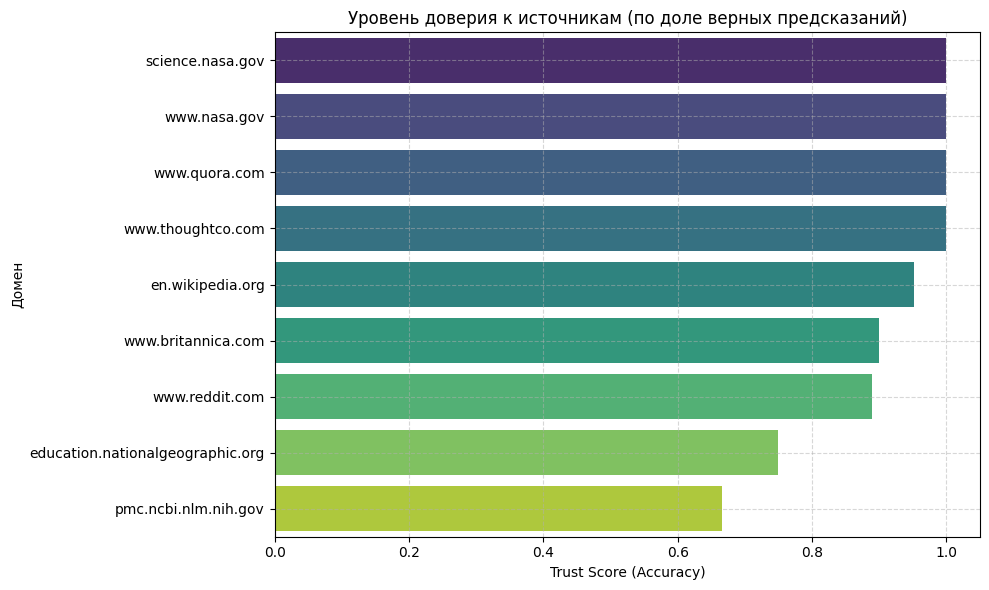

In [147]:
import matplotlib.pyplot as plt
import seaborn as sns

# Построение доверия к доменам
source_records = []
for _, row in results_df.iterrows():
    for domain in row["source_domains"]:
        source_records.append({
            "domain": domain,
            "correct": row["label_pred"] == row["label_true"]
        })

# Подсчёт статистики
source_df = pd.DataFrame(source_records)
source_stats = source_df.groupby("domain")["correct"].agg(["count", "sum"])
source_stats["trust_score"] = source_stats["sum"] / source_stats["count"]
source_stats = source_stats.sort_values("trust_score", ascending=False)

# Визуализация
filtered_stats = source_stats[source_stats["count"] >= 3].copy()

plt.figure(figsize=(10, 6))
sns.barplot(
    data=filtered_stats.reset_index(),
    x="trust_score", y="domain", palette="viridis"
)
plt.title("Уровень доверия к источникам (по доле верных предсказаний)")
plt.xlabel("Trust Score (Accuracy)")
plt.ylabel("Домен")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

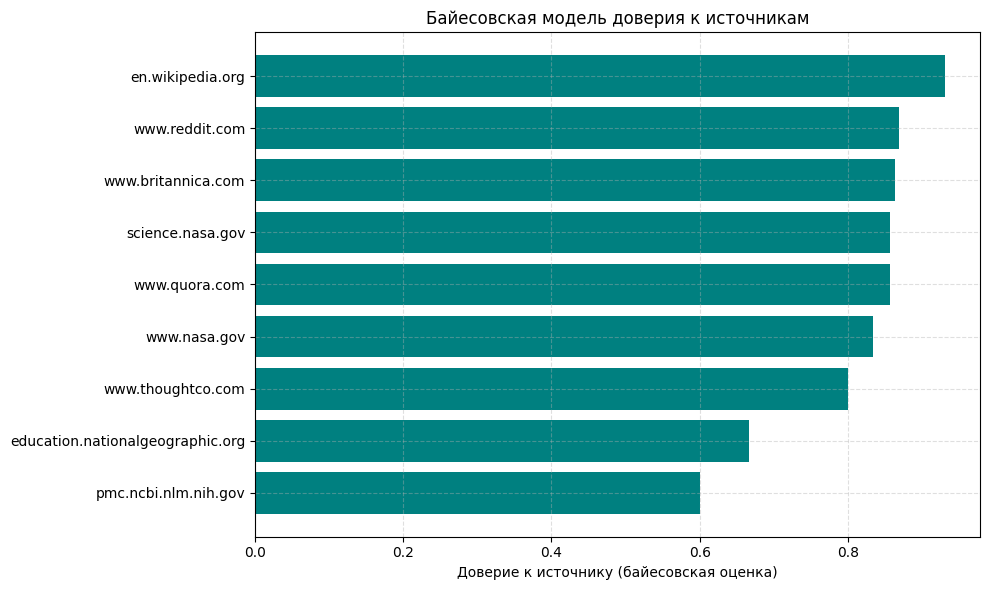

In [153]:
import pandas as pd
import matplotlib.pyplot as plt

# Сводим доверие в датафрейм
trust_df = pd.DataFrame([
    {"domain": domain, "trust_score": get_bayesian_score(domain),
     "successes": stats["alpha"] - 1, "failures": stats["beta"] - 1}
    for domain, stats in bayesian_trust.items()
])

# Оставим только домены с хотя бы 5 наблюдениями
trust_df = trust_df[(trust_df["successes"] + trust_df["failures"]) >= 3]
trust_df = trust_df.sort_values("trust_score", ascending=False)

# Визуализация
plt.figure(figsize=(10, 6))
plt.barh(trust_df["domain"], trust_df["trust_score"], color="teal")
plt.xlabel("Доверие к источнику (байесовская оценка)")
plt.title("Байесовская модель доверия к источникам")
plt.gca().invert_yaxis()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


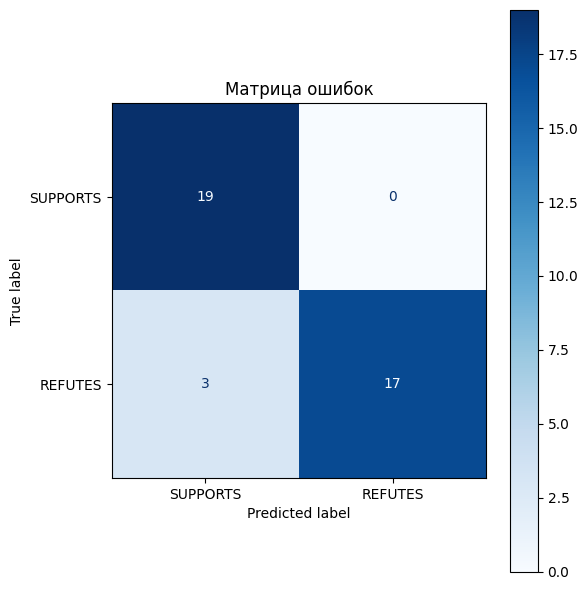

In [159]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 🔹 Убираем "NOT ENOUGH INFO"
filtered_df = results_df[results_df["label_true"].isin(["SUPPORTS", "REFUTES"])].copy()


# Визуализация: Матрица ошибок
labels = ["SUPPORTS", "REFUTES"]
cm = confusion_matrix(filtered_df["label_true"], filtered_df["label_pred"], labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Матрица ошибок")
plt.tight_layout()
plt.show()




In [2]:
def penalize_bayesian_trust(domain, penalty=0.1):
    # Уменьшаем параметр alpha (успехи)
    if domain not in source_stats:
        source_stats[domain] = {"alpha": 1, "beta": 1}
    source_stats[domain]["alpha"] = max(1, source_stats[domain]["alpha"] - penalty)


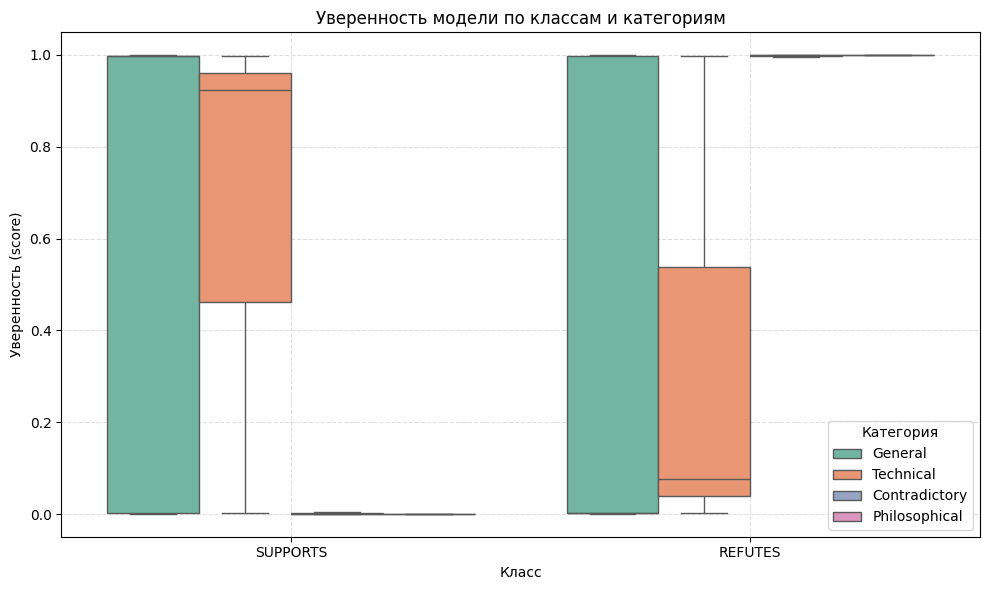

In [165]:
import seaborn as sns
import matplotlib.pyplot as plt

# Удалим класс NOT ENOUGH INFO
filtered_df = results_df.copy()
filtered_df = filtered_df[~filtered_df["label_true"].isin(["NOT ENOUGH INFO"])]
filtered_df = filtered_df[~filtered_df["label_pred"].isin(["NOT ENOUGH INFO"])]

# Обозначим категорию красиво
filtered_df["category_label"] = filtered_df["category"].apply(lambda c: c.capitalize())

# Переименуем классы для оси X
renamed_columns = {
    "score_supports": "SUPPORTS",
    "score_refutes": "REFUTES"
}

# melt
melted_scores = filtered_df.melt(
    id_vars=["category_label"],
    value_vars=list(renamed_columns.keys()),
    var_name="class",
    value_name="score"
)

# Заменим значения в столбце class на заглавные
melted_scores["class"] = melted_scores["class"].map(renamed_columns)

# Палитра
unique_categories = melted_scores["category_label"].unique()
palette = sns.color_palette("Set2", len(unique_categories))
palette_dict = dict(zip(unique_categories, palette))

# Визуализация
plt.figure(figsize=(10, 6))
sns.boxplot(
    data=melted_scores,
    x="class",
    y="score",
    hue="category_label",
    palette=palette_dict
)

plt.title("Уверенность модели по классам и категориям")
plt.xlabel("Класс")
plt.ylabel("Уверенность (score)")
plt.legend(title="Категория")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()
